# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.2 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load the YS progenitors

In [3]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/liver/data/ys_total_annotation_20191127.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 10071 × 32084 
    obs: 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'cell.labels', 'fetal.ids', 'sort.ids', 'tissue', 'lanes', 'stages', 'sample.type', 'gender', 'AnnatomicalPart', 'doublets', 'LouvainClustering', 'predicted.cell.labels', 'full.ids', 'batch', 'bh_pval', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'n_counts', 'louvain', 'is_doublet', 'is_doublet_poptrim', 'res.30', 'backlabeled_1'

In [5]:
adata.raw = adata

In [6]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
DC progenitor                78
Early mast cell             133
Endothelium                 160
Erythroid AB                892
Erythroid EZ               1167
Erythroid M                 275
ILC precursor                25
Lymphoid progenitor         184
MEMP                        121
Monocyte                     38
Myeloid progenitor           61
NK early                     50
yolk sac Macrophage I      3063
yolk sac Macrophage II     3619
yolk sac progenitor/MPP     205
dtype: int64

In [7]:
adata = adata[adata.obs['cell.labels'].isin(['yolk sac progenitor/MPP', 'Lymphoid progenitor', 'Myeloid progenitor', 
                                            'MEMP'])].copy()

In [8]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
Lymphoid progenitor        184
MEMP                       121
Myeloid progenitor          61
yolk sac progenitor/MPP    205
dtype: int64

# Pre-process the FL progenitor dataset

In [9]:
# normalise count data 
sc.pp.normalize_total(adata)

In [10]:
# log the count data 
sc.pp.log1p(adata)

In [11]:
adata

AnnData object with n_obs × n_vars = 571 × 32084 
    obs: 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'cell.labels', 'fetal.ids', 'sort.ids', 'tissue', 'lanes', 'stages', 'sample.type', 'gender', 'AnnatomicalPart', 'doublets', 'LouvainClustering', 'predicted.cell.labels', 'full.ids', 'batch', 'bh_pval', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'n_counts', 'louvain', 'is_doublet', 'is_doublet_poptrim', 'res.30', 'backlabeled_1'

In [12]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [13]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [14]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [15]:
# run pca
sc.tl.pca(adata, n_comps=50)

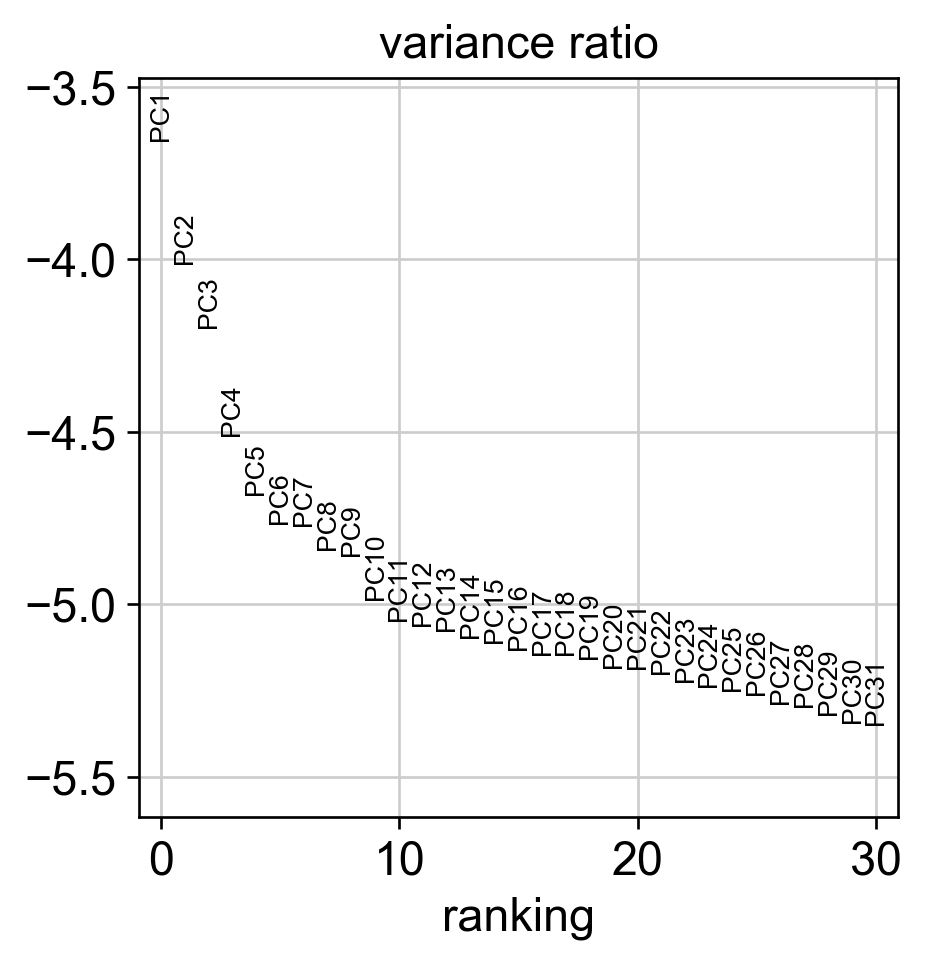

In [16]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [17]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10) 

In [18]:
# run umap
sc.tl.umap(adata) 

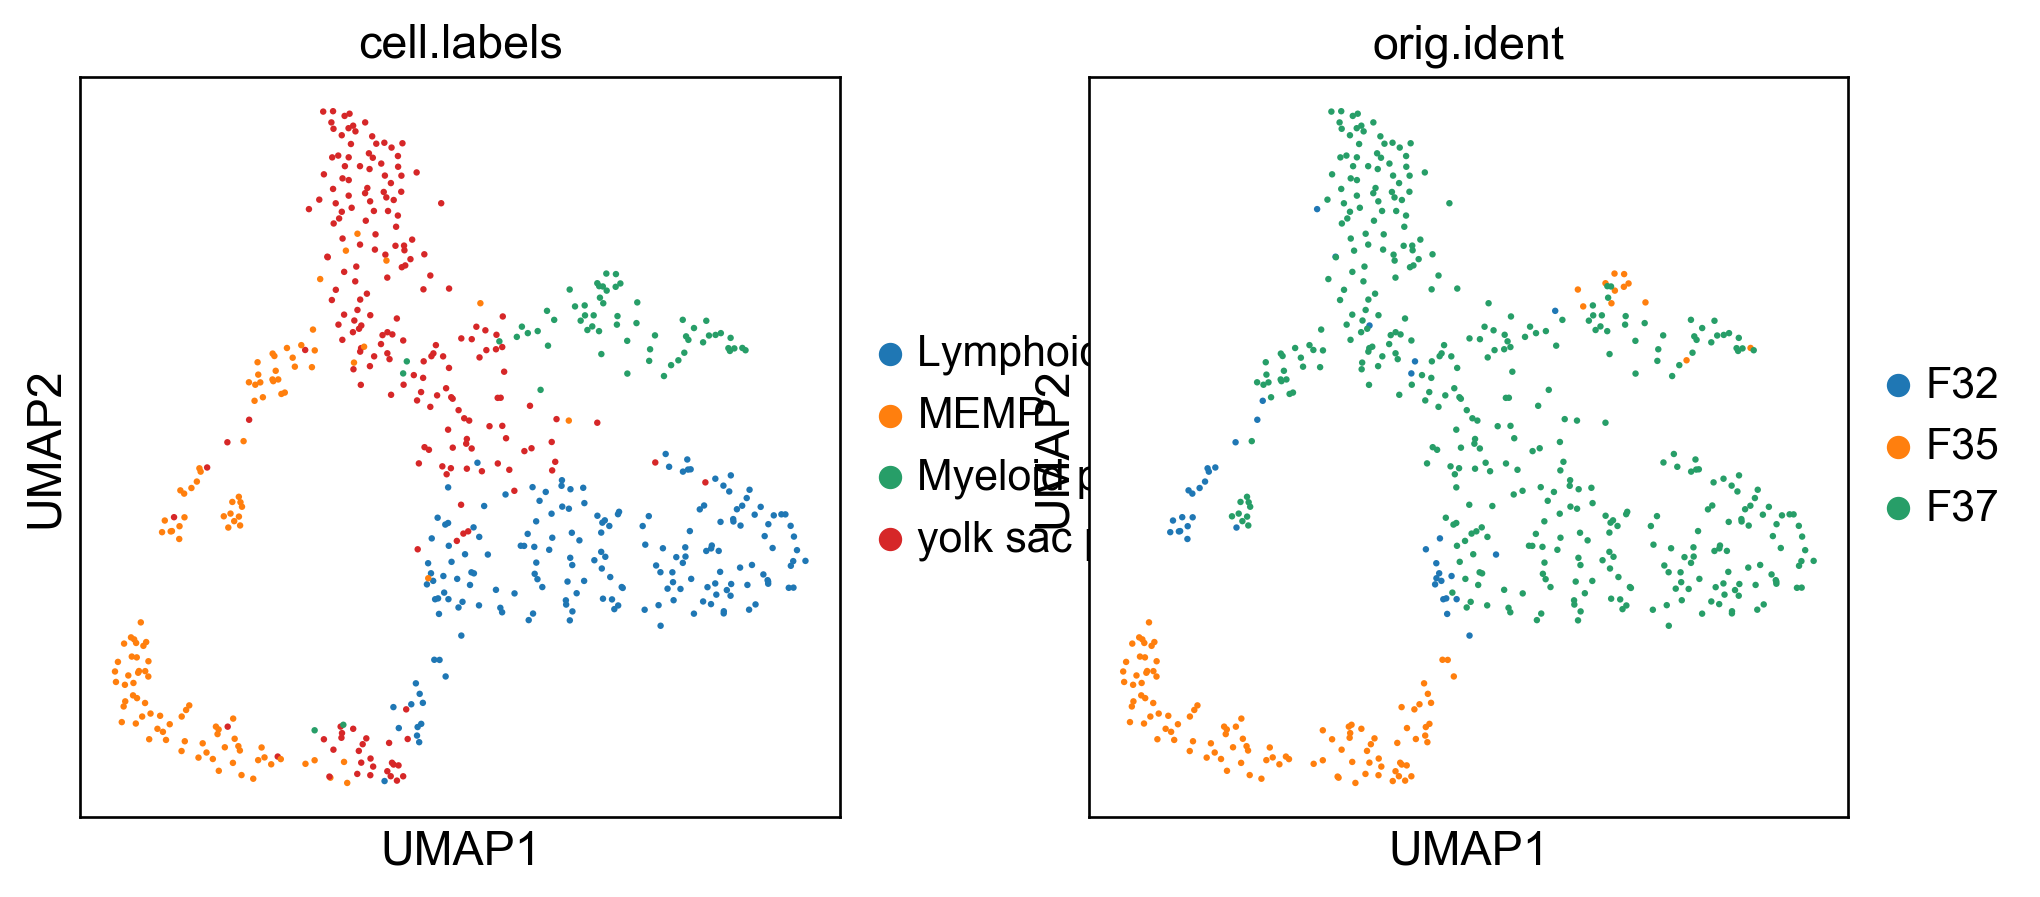

In [19]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

# Run harmony batch correction

In [20]:
#harmony prep - save pca and batch (sample) metadata columns 
pca = adata.obsm['X_pca']
batch = adata.obs['orig.ident']

In [21]:
# load up harmony in rpy2
%load_ext rpy2.ipython

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [22]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

hem = HarmonyMatrix(pca, batch, theta=3, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

R[write to console]: Harmony converged after 6 iterations



In [23]:
# save old pca values or orig.pca and save batch corrected pca results in anndata object as x_pca
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

# Add dimensional reduction post-harmony

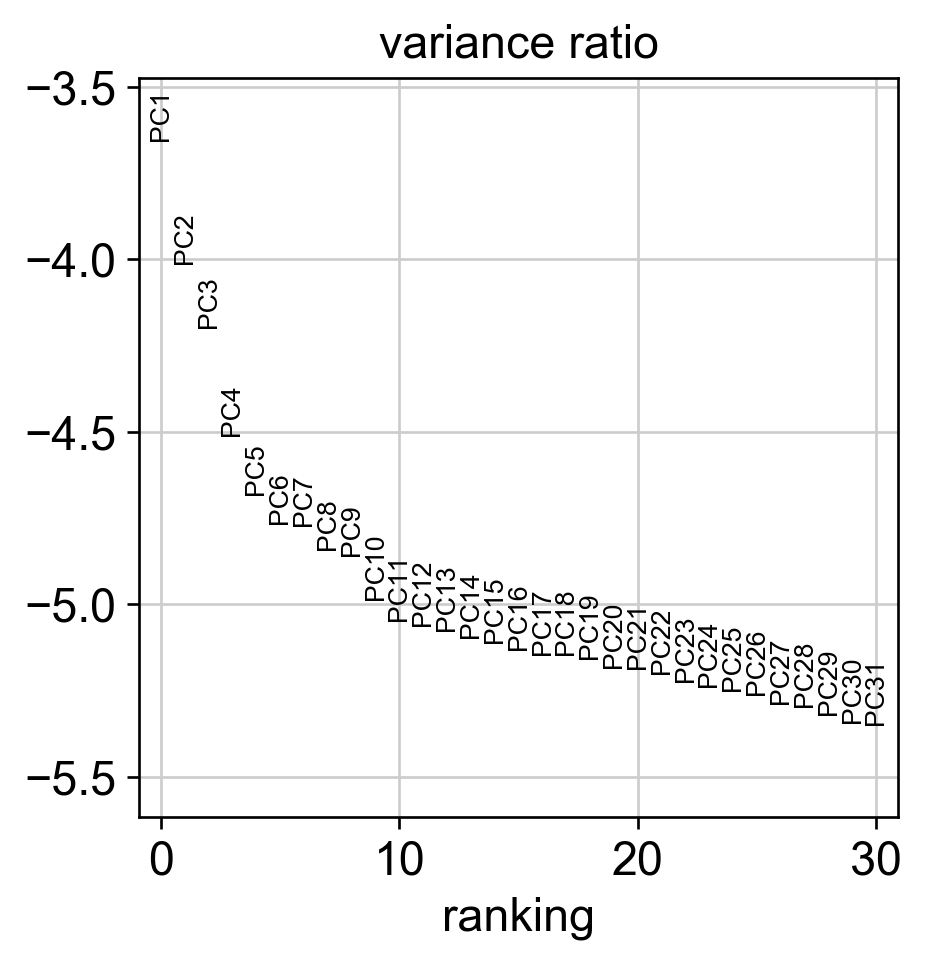

In [24]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [25]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10) 

In [26]:
# run umap
sc.tl.umap(adata)

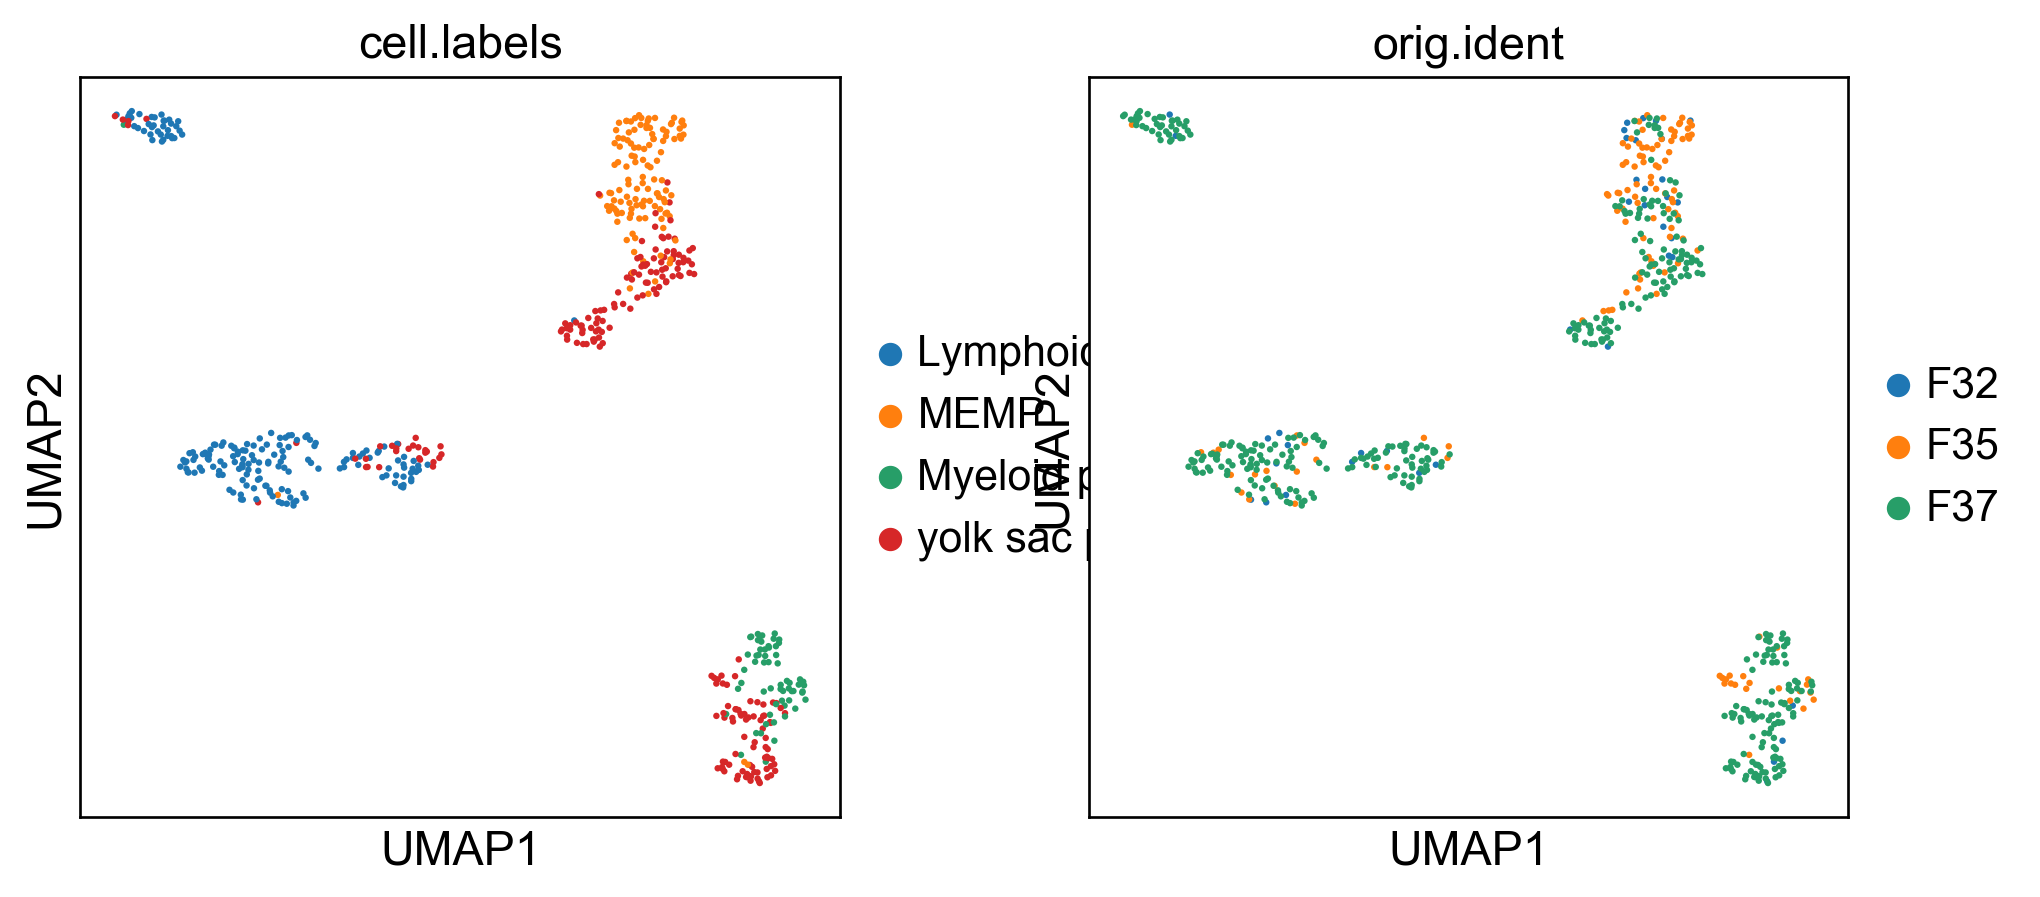

In [27]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

# Cluster FL progenitor to around 20 groups

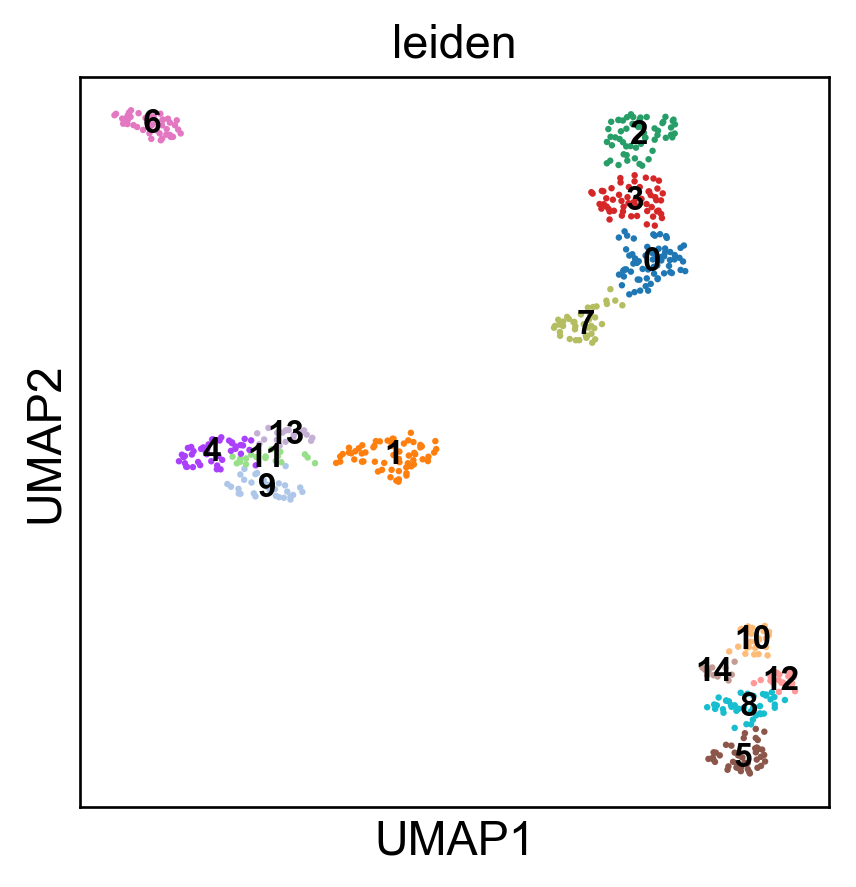

In [28]:
sc.tl.leiden(adata, resolution=3, random_state=26, n_iterations=-1) 
sc.pl.umap(adata, color='leiden', legend_loc="on data", size=15, legend_fontsize=10)

In [29]:
cell_numbers = adata.obs.groupby(["leiden"]).apply(len)
cell_numbers

leiden
0     65
1     61
2     56
3     55
4     45
5     44
6     42
7     40
8     40
9     31
10    26
11    19
12    18
13    18
14    11
dtype: int64

In [30]:
scrna_data = adata

# Run DEGs for YS progen

In [31]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [32]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [33]:
# run degs on normalised and logged data (saved as adata.raw), not on additionally scaled data (saved as adata.X).
# calculate degs using wilcoxon rank sum test with benjamini-hochberg correction. 
#based on ln transformed count data 
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon', use_raw=False, log_transformed=True)

In [34]:
# filter the degs for those which are expressed in at least 25% of cells in cluster. log2fc of the ln-transformed
# data will be shown.
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.25, min_fold_change=0.25, use_raw=False)

In [35]:
# save df for unfiltered degs
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs_by_cluster = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']})

# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/figs/clustering_degs/ys_progen_degs.csv")
degs_by_cluster[:10]

,0_n,0_l,1_n,1_l,2_n,2_l,3_n,3_l,4_n,4_l,...,10_n,10_l,11_n,11_l,12_n,12_l,13_n,13_l,14_n,14_l
0,RPL7,2.707385,HACD1,2.364310,BLVRB,6.586924,CNRIP1,4.429195,CD74,4.248207,...,FCN1,9.895093,ACY3,3.300285,MPO,6.853322,JCHAIN,5.263569,LRRC75A,3.454860
1,RPS14,2.357319,TMA7,2.326727,HBG2,6.318049,MT-CO2,3.113071,ACY3,3.428156,...,MNDA,8.476527,CD74,2.789910,AZU1,8.297706,LTB,4.812645,HSD17B11,2.905910
2,RPS3A,2.437075,JCHAIN,2.418289,HBG1,6.709812,MT-CO1,2.964167,TMSB4X,3.149383,...,S100A9,8.106902,TMSB4X,2.644803,SRGN,6.370027,EVI2A,2.993423,FRZB,3.406505
3,RPS6,2.456831,ISG15,3.118704,PRDX2,7.267815,MT-CO3,2.945889,GPR183,3.829252,...,S100A8,8.507233,GSN,3.316981,RPLP2,6.897525,BANK1,4.568280,LUM,2.948394
4,RPL18A,2.450766,C11orf31,1.895562,MYL4,6.154896,MT-ND3,2.949529,CD83,3.945439,...,S100A11,5.726321,GPX1,3.114807,RPLP1,6.389560,CD7,3.302208,UQCRHL,3.319900
5,RPL10A,2.679679,LSP1,1.510313,GYPA,5.783144,SLC40A1,4.106755,B2M,3.644660,...,LYZ,6.579262,LSP1,2.440491,RP11-1143G9.4,6.834444,MZB1,4.940402,ALB,3.499431
6,RPL31,2.650383,PSME2,2.118768,AHSP,7.037794,MT-ATP6,2.908491,JAML,3.313652,...,S100A12,8.814713,PLD4,2.773800,LYZ,6.406274,IL7R,4.801694,RPL17,3.280876
7,MDK,3.021139,CORO1A,1.420093,RFESD,6.697989,GATA1,4.004452,HLA-DRA,3.915936,...,VIM,5.028207,ACTB,2.597323,PRTN3,7.782172,CD99,3.230882,NHSL2,3.079703
8,RPL15,2.334861,COX7A2,1.933449,ALAS2,5.803288,KLF1,3.260428,ACTB,2.861628,...,CSTA,7.482852,S100B,4.188828,TSPO,5.266817,HADH,3.672756,NBEAL1,3.125631
9,RPL9,2.414174,ERH,1.745364,GYPB,4.864149,MT-ND2,2.898133,GSN,3.112218,...,TSPO,6.398751,TOX,3.195373,RPS28,4.850035,CYTIP,3.088679,CSF3R,3.584292


In [36]:
# save df for filtered degs
result = adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
degs_by_cluster_filtered = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']})
# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster_filtered.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/figs/clustering_degs/ys_progen_degs_filtered.csv")
degs_by_cluster_filtered[:10]

,0_n,0_l,1_n,1_l,2_n,2_l,3_n,3_l,4_n,4_l,...,10_n,10_l,11_n,11_l,12_n,12_l,13_n,13_l,14_n,14_l
0,RPL7,2.707385,HACD1,2.364310,BLVRB,6.586924,CNRIP1,4.429195,CD74,4.248207,...,FCN1,9.895093,ACY3,3.300285,MPO,6.853322,JCHAIN,5.263569,LRRC75A,3.454860
1,RPS14,2.357319,TMA7,2.326727,HBG2,6.318049,MT-CO2,3.113071,ACY3,3.428156,...,MNDA,8.476527,CD74,2.789910,AZU1,8.297706,LTB,4.812645,HSD17B11,2.905910
2,RPS3A,2.437075,JCHAIN,2.418289,HBG1,6.709812,MT-CO1,2.964167,TMSB4X,3.149383,...,S100A9,8.106902,TMSB4X,2.644803,SRGN,6.370027,EVI2A,2.993423,FRZB,3.406505
3,RPS6,2.456831,ISG15,3.118704,PRDX2,7.267815,MT-CO3,2.945889,GPR183,3.829252,...,S100A8,8.507233,GSN,3.316981,RPLP2,6.897525,BANK1,4.568280,LUM,2.948394
4,RPL18A,2.450766,C11orf31,1.895562,MYL4,6.154896,MT-ND3,2.949529,CD83,3.945439,...,S100A11,5.726321,GPX1,3.114807,RPLP1,6.389560,CD7,3.302208,UQCRHL,3.319900
5,RPL10A,2.679679,LSP1,1.510313,GYPA,5.783144,SLC40A1,4.106755,B2M,3.644660,...,LYZ,6.579262,LSP1,2.440491,RP11-1143G9.4,6.834444,MZB1,4.940402,ALB,3.499431
6,RPL31,2.650383,PSME2,2.118768,AHSP,7.037794,MT-ATP6,2.908491,JAML,3.313652,...,S100A12,8.814713,PLD4,2.773800,LYZ,6.406274,IL7R,4.801694,RPL17,3.280876
7,MDK,3.021139,CORO1A,1.420093,RFESD,6.697989,GATA1,4.004452,HLA-DRA,3.915936,...,VIM,5.028207,ACTB,2.597323,PRTN3,7.782172,CD99,3.230882,NHSL2,3.079703
8,RPL15,2.334861,COX7A2,1.933449,ALAS2,5.803288,KLF1,3.260428,ACTB,2.861628,...,CSTA,7.482852,S100B,4.188828,TSPO,5.266817,HADH,3.672756,NBEAL1,3.125631
9,RPL9,2.414174,ERH,1.745364,GYPB,4.864149,MT-ND2,2.898133,GSN,3.112218,...,TSPO,6.398751,TOX,3.195373,RPS28,4.850035,CYTIP,3.088679,CSF3R,3.584292


# Run DEGs for the FBM progen and select top 100 genes

In [37]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig5a_progen_dr_20200512.h5ad")

In [38]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC                         92
MPP myeloid 1               46
MPP myeloid 2               46
CMP                        425
GMP                       1285
MEMP                        16
MEP                        269
eo/baso/mast precursor     175
MPP lymphoid                34
ELP                       1358
dtype: int64

In [39]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].replace(["MPP myeloid 1", "MPP myeloid 2"], ["MPP myeloid", "MPP myeloid"])

In [40]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['CMP', 'ELP', 'GMP', 'HSC', 'MEMP', 'MEP', 'MPP lymphoid',
       'MPP myeloid', 'eo/baso/mast precursor'],
      dtype='object')

In [41]:
# order tissue_cell.labels column

final_order = ['CMP', 'ELP', 'GMP', 'HSC', 'MEMP', 'MEP', 'MPP lymphoid',
       'MPP myeloid', 'eo/baso/mast precursor']

adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories(final_order)

cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CMP                        425
ELP                       1358
GMP                       1285
HSC                         92
MEMP                        16
MEP                        269
MPP lymphoid                34
MPP myeloid                 92
eo/baso/mast precursor     175
dtype: int64

# Preprocess data

In [42]:
# run degs on normalised and logged data (saved as adata.raw), not on additionally scaled data (saved as adata.X).
# calculate degs using wilcoxon rank sum test with benjamini-hochberg correction. 
#based on ln transformed count data 
sc.tl.rank_genes_groups(adata, groupby='cell.labels', method='wilcoxon', use_raw=False, log_transformed=True, n_genes=1000)

In [43]:
# filter the degs for those which are expressed in at least 25% of cells in cluster. log2fc of the ln-transformed
# data will be shown.
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.25, min_fold_change=0.25, use_raw=False)

In [44]:
# save df for unfiltered degs
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs_by_cluster = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']})

# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/figs/clustering_degs/fbm_progen_degs.csv")
degs_by_cluster[:10]

,CMP_n,CMP_l,ELP_n,ELP_l,GMP_n,GMP_l,HSC_n,HSC_l,MEMP_n,MEMP_l,MEP_n,MEP_l,MPP lymphoid_n,MPP lymphoid_l,MPP myeloid_n,MPP myeloid_l,eo/baso/mast precursor_n,eo/baso/mast precursor_l
0,DLK1,2.698492,LTB,7.681231,MPO,3.548792,MLLT3,6.256437,HPGDS,4.220843,GATA1,6.434282,SPINK2,3.161551,SPINK2,3.106188,LMO4,5.754534
1,RAB7B,3.485019,VPREB1,6.639174,LYZ,5.187099,HOPX,5.253652,GATA2,3.606015,SLC40A1,5.131162,LSP1,2.182618,SMIM24,2.124512,GATA2,5.043895
2,PYGL,2.187703,ADA,5.005445,SRGN,3.763866,NPR3,6.197396,TESPA1,4.287183,CNRIP1,6.799185,HOPX,3.642089,ANGPT1,3.433977,IL5RA,8.069749
3,TRH,2.045348,ZCCHC7,6.487932,PRTN3,4.648438,CYTL1,3.494164,TALDO1,2.276086,MINPP1,5.058672,SMIM24,2.193235,CD34,2.528964,CD63,3.540837
4,CD34,1.673626,CD79A,7.461641,RNASE2,4.150216,NRIP1,4.105063,RPL5,2.166248,KLF1,7.084733,CD37,2.025628,SELL,2.445330,HPGDS,4.444115
5,CALR,1.711001,C5orf56,5.671171,AZU1,4.428249,SPINK2,3.115034,NPR3,3.943182,SDPR,4.640088,CD52,2.462228,RPL15,2.042299,AC004791.2,7.095630
6,SMIM24,1.466436,LST1,4.335283,CTSG,4.994599,GNG11,3.687930,MARCKSL1,2.292264,MYH10,7.198076,CD34,2.660931,HOPX,2.951954,PRG2,6.254858
7,C1orf186,2.477777,RCSD1,4.426806,PLAC8,2.832504,RGS10,3.064665,TAGLN2,2.442278,UROD,3.866369,SELL,2.048036,IL1B,2.748654,MS4A3,2.902920
8,CSF3R,1.618726,IGHM,5.749119,MS4A3,2.810637,CD52,3.232269,IL1B,3.549868,FTH1,2.574545,FTH1,1.488192,ICAM3,2.024261,CSF2RB,5.221204
9,SPINK2,1.585074,TCF4,4.533305,CSTA,4.830257,CD164,3.024751,EEF1A1,2.055338,EMP3,3.160665,MZB1,2.443366,RPS3,1.704024,ANXA1,3.924520


In [45]:
# save df for filtered degs
result = adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
degs_by_cluster_filtered = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']})
# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster_filtered.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/figs/clustering_degs/fbm_progen_degs_filtered.csv")
degs_by_cluster_filtered[:10]

,CMP_n,CMP_l,ELP_n,ELP_l,GMP_n,GMP_l,HSC_n,HSC_l,MEMP_n,MEMP_l,MEP_n,MEP_l,MPP lymphoid_n,MPP lymphoid_l,MPP myeloid_n,MPP myeloid_l,eo/baso/mast precursor_n,eo/baso/mast precursor_l
0,DLK1,2.698492,LTB,7.681231,MPO,3.548792,MLLT3,6.256437,HPGDS,4.220843,GATA1,6.434282,SPINK2,3.161551,SPINK2,3.106188,LMO4,5.754534
1,RAB7B,3.485019,VPREB1,6.639174,LYZ,5.187099,HOPX,5.253652,GATA2,3.606015,SLC40A1,5.131162,NaN,2.182618,NaN,2.124512,GATA2,5.043895
2,PYGL,2.187703,ADA,5.005445,SRGN,3.763866,NPR3,6.197396,TESPA1,4.287183,CNRIP1,6.799185,HOPX,3.642089,ANGPT1,3.433977,IL5RA,8.069749
3,TRH,2.045348,ZCCHC7,6.487932,PRTN3,4.648438,CYTL1,3.494164,NaN,2.276086,MINPP1,5.058672,NaN,2.193235,CD34,2.528964,NaN,3.540837
4,CD34,1.673626,CD79A,7.461641,RNASE2,4.150216,NRIP1,4.105063,NaN,2.166248,KLF1,7.084733,NaN,2.025628,SELL,2.445330,HPGDS,4.444115
5,CALR,1.711001,C5orf56,5.671171,AZU1,4.428249,SPINK2,3.115034,NPR3,3.943182,SDPR,4.640088,CD52,2.462228,NaN,2.042299,AC004791.2,7.095630
6,NaN,1.466436,LST1,4.335283,CTSG,4.994599,GNG11,3.687930,NaN,2.292264,MYH10,7.198076,CD34,2.660931,HOPX,2.951954,PRG2,6.254858
7,C1orf186,2.477777,RCSD1,4.426806,PLAC8,2.832504,NaN,3.064665,NaN,2.442278,UROD,3.866369,SELL,2.048036,IL1B,2.748654,MS4A3,2.902920
8,CSF3R,1.618726,IGHM,5.749119,MS4A3,2.810637,CD52,3.232269,IL1B,3.549868,NaN,2.574545,NaN,1.488192,NaN,2.024261,CSF2RB,5.221204
9,SPINK2,1.585074,TCF4,4.533305,CSTA,4.830257,CD164,3.024751,NaN,2.055338,EMP3,3.160665,MZB1,2.443366,NaN,1.704024,ANXA1,3.924520


In [46]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CMP                        425
ELP                       1358
GMP                       1285
HSC                         92
MEMP                        16
MEP                        269
MPP lymphoid                34
MPP myeloid                 92
eo/baso/mast precursor     175
dtype: int64

# Save top 100 filtered DEGs within dictionary

In [47]:
# sort the degs_by_cluster_filtered df genes by logfc
df = degs_by_cluster_filtered
df[:5]

,CMP_n,CMP_l,ELP_n,ELP_l,GMP_n,GMP_l,HSC_n,HSC_l,MEMP_n,MEMP_l,MEP_n,MEP_l,MPP lymphoid_n,MPP lymphoid_l,MPP myeloid_n,MPP myeloid_l,eo/baso/mast precursor_n,eo/baso/mast precursor_l
0,DLK1,2.698492,LTB,7.681231,MPO,3.548792,MLLT3,6.256437,HPGDS,4.220843,GATA1,6.434282,SPINK2,3.161551,SPINK2,3.106188,LMO4,5.754534
1,RAB7B,3.485019,VPREB1,6.639174,LYZ,5.187099,HOPX,5.253652,GATA2,3.606015,SLC40A1,5.131162,NaN,2.182618,NaN,2.124512,GATA2,5.043895
2,PYGL,2.187703,ADA,5.005445,SRGN,3.763866,NPR3,6.197396,TESPA1,4.287183,CNRIP1,6.799185,HOPX,3.642089,ANGPT1,3.433977,IL5RA,8.069749
3,TRH,2.045348,ZCCHC7,6.487932,PRTN3,4.648438,CYTL1,3.494164,NaN,2.276086,MINPP1,5.058672,NaN,2.193235,CD34,2.528964,NaN,3.540837
4,CD34,1.673626,CD79A,7.461641,RNASE2,4.150216,NRIP1,4.105063,NaN,2.166248,KLF1,7.084733,NaN,2.025628,SELL,2.445330,HPGDS,4.444115


In [48]:
my_dict = {}

for i in adata.obs["cell.labels"].cat.categories:
    # for each DEG list
    print(i)
    # assign cols
    gene_name = str(i) + "_n"
    logfc = str(i) + "_l"
    
    # sort values of genes based on logfc
    df = df.sort_values([logfc], ascending=False)
    gene_list = df[gene_name].tolist()
    # remove nan values from genes
    cleanedList = [x for x in gene_list if str(x) != 'nan']
    #get top 100 genes
    top_100_genes = cleanedList[:100] 
    # save 100 degs as values in key named "celltype"_degs
    x = str(i) + "_degs"
    my_dict[x] = top_100_genes

#del my_dict['nan_degs']

CMP
ELP
GMP
HSC
MEMP
MEP
MPP lymphoid
MPP myeloid
eo/baso/mast precursor


# Run score comparisons

In [49]:
adata = scrna_data

In [50]:
# run through DEG list for each cell type, run score_genes function on adata object for these genes and save in .obs
celltypes_string_list = list(my_dict.keys())

DEG_lists=my_dict.values()
counter=0

for i in DEG_lists:
    sc.tl.score_genes(adata, gene_list=i, score_name=celltypes_string_list[counter])
    counter=counter+1

In [51]:
# save cell cycle scores within metadata as a dataframe (called enrichement scores)
adata.obs["labels"] = adata.obs["leiden"]
meta = pd.DataFrame(adata.obs)
enrichment_scores_df = meta[meta.columns[-10:]]
enrichment_scores_df

,CMP_degs,ELP_degs,GMP_degs,HSC_degs,MEMP_degs,MEP_degs,MPP lymphoid_degs,MPP myeloid_degs,eo/baso/mast precursor_degs,labels
index,,,,,,,,,,
F32_yolk sac_Total_FCAImmP7316900_ATCCACCGTGTTTGGT,-0.019274,1.597553,-0.165395,-0.079082,-0.108394,-0.227650,0.124708,0.053951,-0.213729,13
F32_yolk sac_Total_FCAImmP7316900_CCATGTCTCAGCTTAG,-0.154124,1.437997,-0.188172,-0.238409,0.036661,-0.149540,0.301668,-0.157143,-0.192517,13
F32_yolk sac_Total_FCAImmP7316900_CTACCCAAGCCCGAAA,-0.014384,0.979569,-0.227933,-0.174957,-0.246335,-0.218741,-0.013805,-0.137772,-0.216477,1
F32_yolk sac_Total_FCAImmP7316900_CTTAGGATCACTATTC,-0.097084,0.509513,-0.276392,0.238111,-0.133021,-0.210490,0.519237,0.173161,-0.169468,1
F32_yolk sac_Total_FCAImmP7316900_GGTGCGTTCGTCTGAA,-0.108226,0.991988,-0.271388,0.031531,-0.265722,-0.122899,0.450174,0.059469,-0.161215,1
...,...,...,...,...,...,...,...,...,...,...
F37_yolk sac_Total_FCAImmP7504909_TGACGGCGTCCTCCAT,0.049585,-0.072296,-0.030158,0.000925,0.398313,0.135719,0.043702,0.084570,0.584356,3
F37_yolk sac_Total_FCAImmP7504909_TGAGCATAGTTGAGAT,0.074478,-0.088629,-0.026698,0.134270,0.104767,0.507246,0.036675,0.043811,0.284208,3
F37_yolk sac_Total_FCAImmP7504909_TTTACTGCACATGACT,0.249512,-0.163713,0.043716,-0.073584,0.491384,-0.069402,-0.046035,-0.028469,0.672660,5


In [52]:
# calculate mean enrichment scores by celltype
mean_enrichment_scores_df = enrichment_scores_df.groupby('labels').mean()
mean_enrichment_scores_df = mean_enrichment_scores_df.T
mean_enrichment_scores_df

labels,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
CMP_degs,0.086215,-0.044226,-0.029090,0.022433,-0.070651,0.227500,-0.020882,0.114472,0.139712,-0.089524,-0.020229,-0.041177,0.017673,-0.147436,0.244581
ELP_degs,-0.029525,0.182704,-0.111179,-0.061016,0.176731,-0.080657,0.009619,0.003937,-0.055925,0.202262,-0.018211,0.257630,-0.049230,0.742397,0.071215
GMP_degs,-0.100639,-0.133471,-0.182455,-0.138602,-0.028208,0.022589,0.052532,-0.094798,0.193911,-0.106726,0.766244,-0.060407,1.315504,-0.161180,0.142453
HSC_degs,0.329621,-0.034404,-0.047257,0.035436,-0.043794,0.007674,-0.088614,0.334633,-0.117208,-0.087530,-0.127072,-0.075810,-0.110300,-0.015233,0.098875
MEMP_degs,0.139590,-0.038203,0.104494,0.281472,-0.049448,0.104422,-0.037439,0.127529,-0.035843,-0.040613,-0.076953,-0.029385,-0.034978,-0.074420,0.086904
MEP_degs,0.005332,-0.181911,0.763721,0.534539,-0.204161,-0.145258,-0.209057,-0.093594,-0.171270,-0.187824,-0.140899,-0.208198,-0.152985,-0.204388,-0.111689
MPP lymphoid_degs,0.099647,0.096495,-0.067861,-0.026773,0.027019,0.050558,-0.024838,0.160818,-0.015350,0.063854,-0.064415,0.080835,-0.107904,0.186129,0.113174
MPP myeloid_degs,0.241202,-0.011502,-0.069708,0.054638,-0.036542,0.112591,-0.076260,0.292273,-0.062281,-0.059066,-0.039924,-0.032263,-0.105406,0.002483,0.252681
eo/baso/mast precursor_degs,0.060309,-0.138624,0.087063,0.340735,-0.044986,0.058872,-0.018646,-0.043308,-0.101025,-0.066495,0.116211,-0.100476,0.105827,-0.136685,0.116222


# Run heatmap

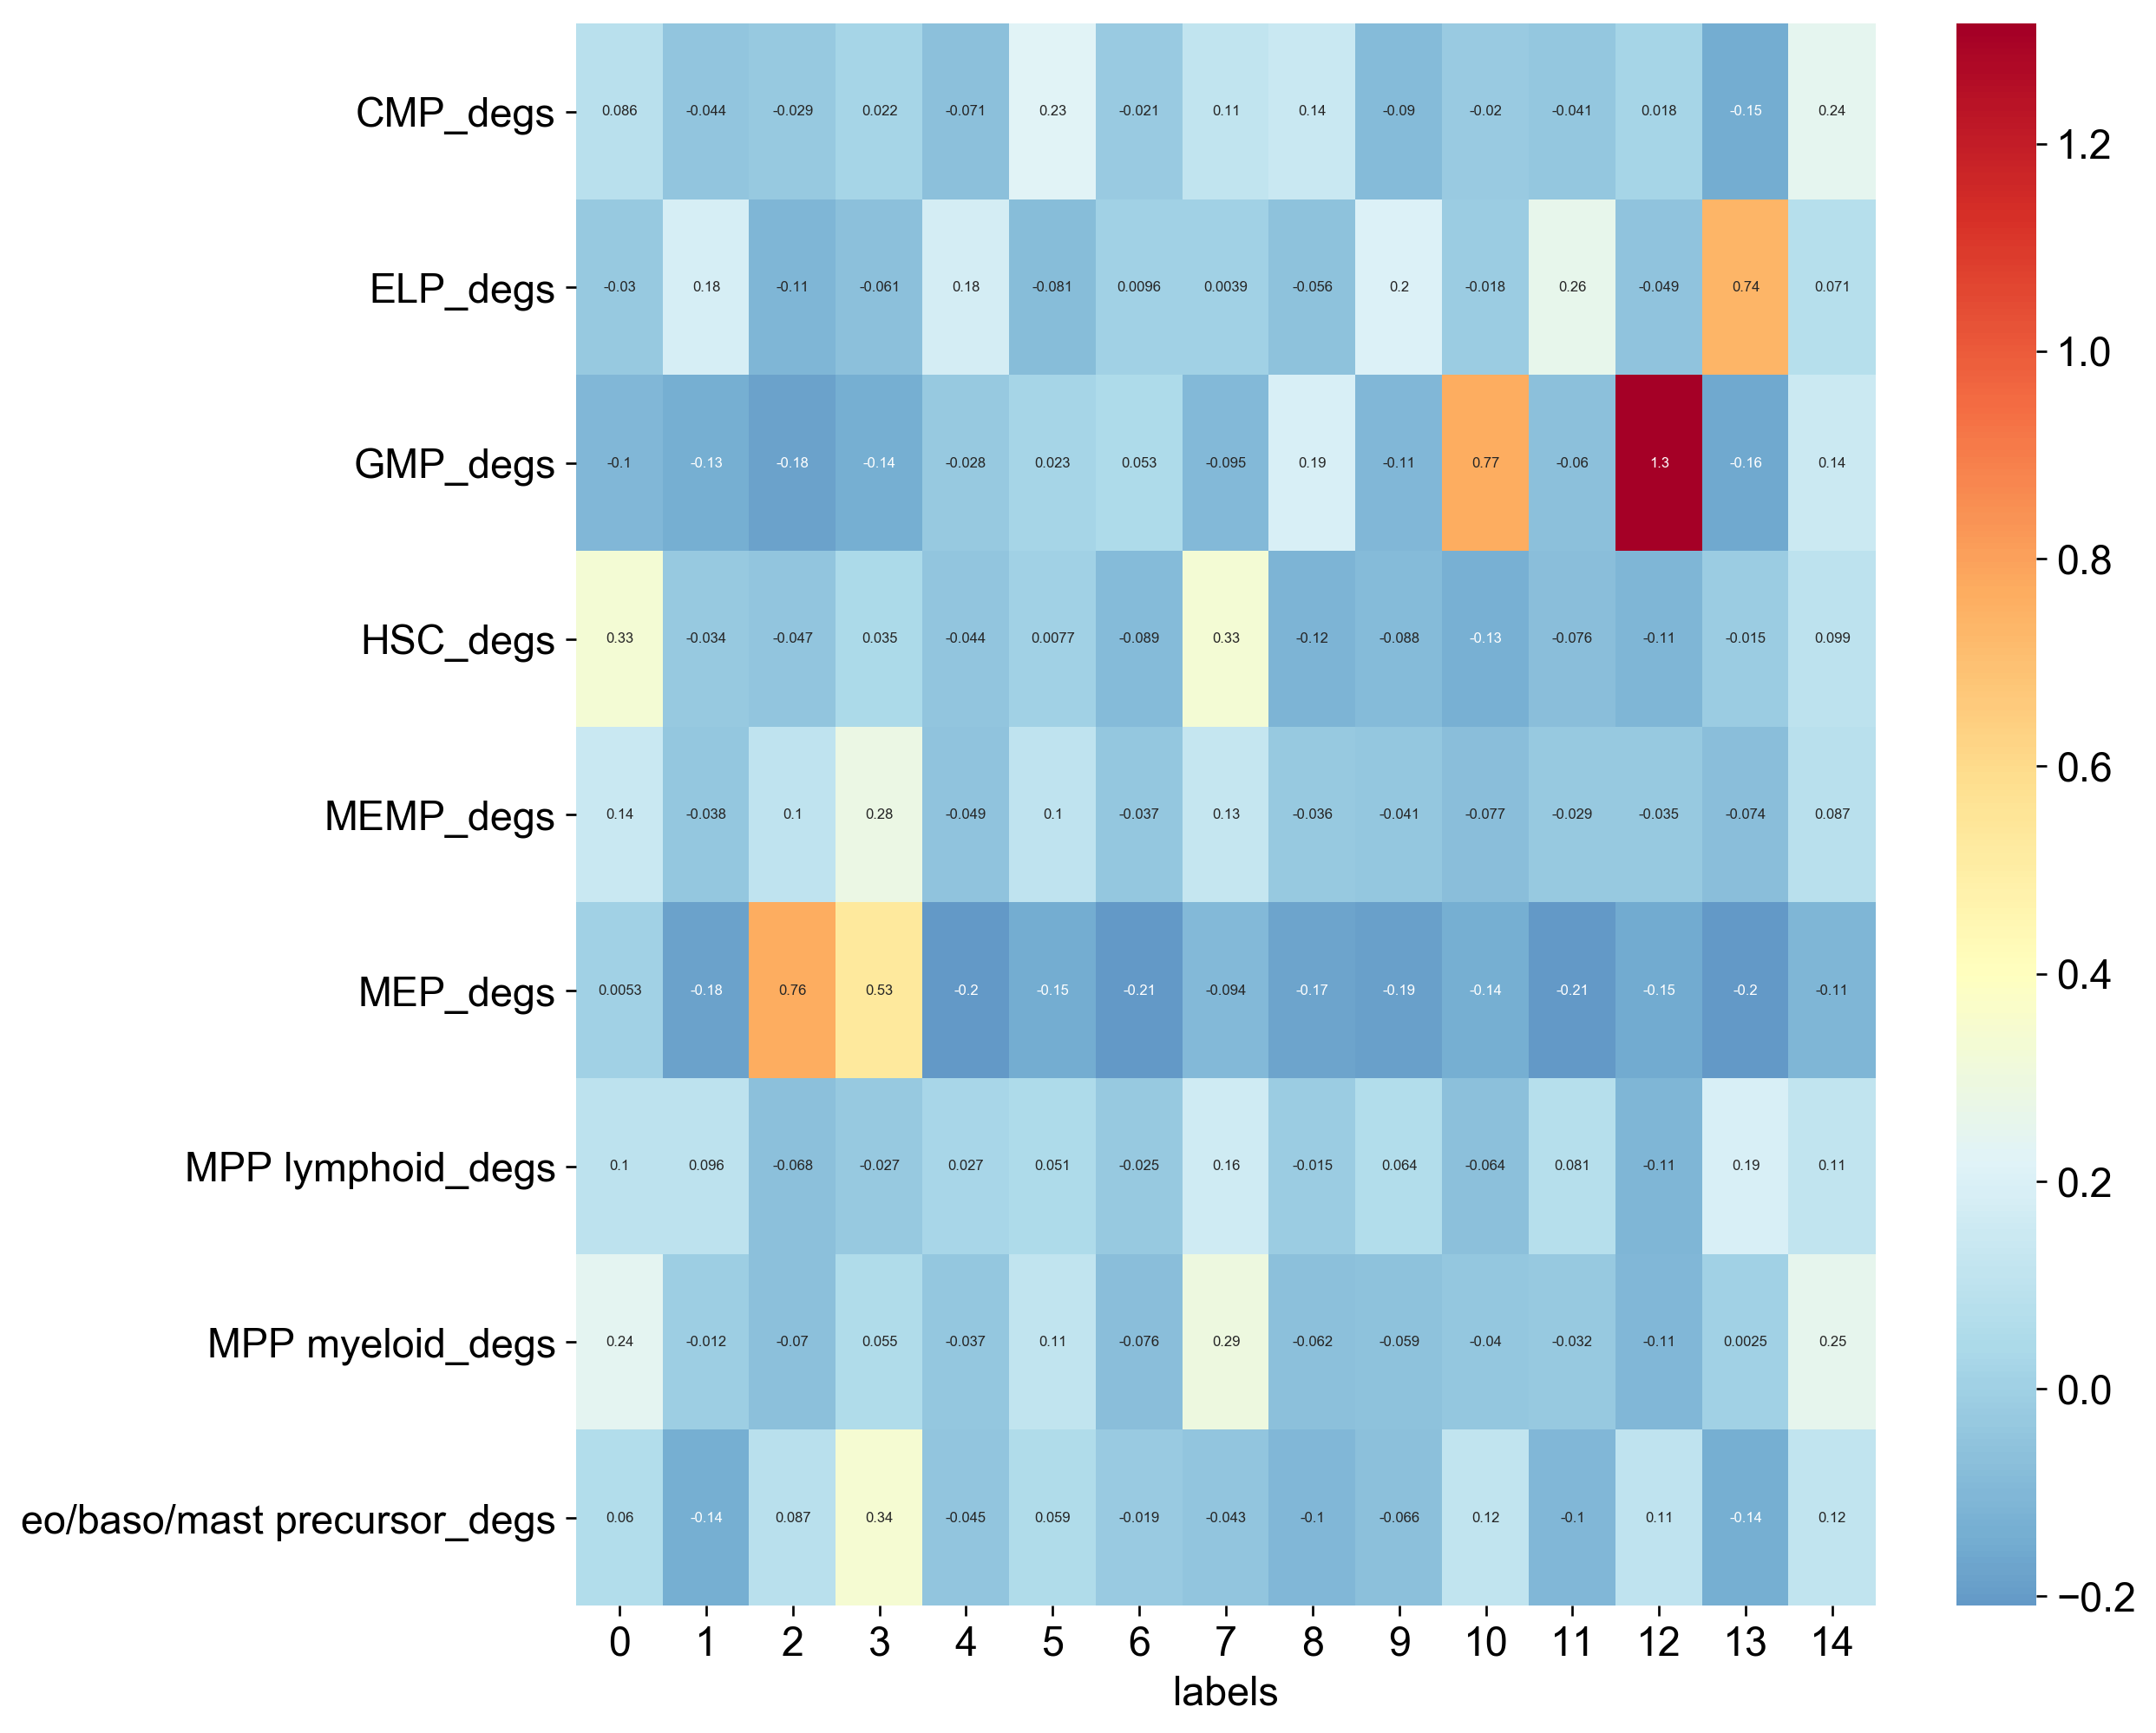

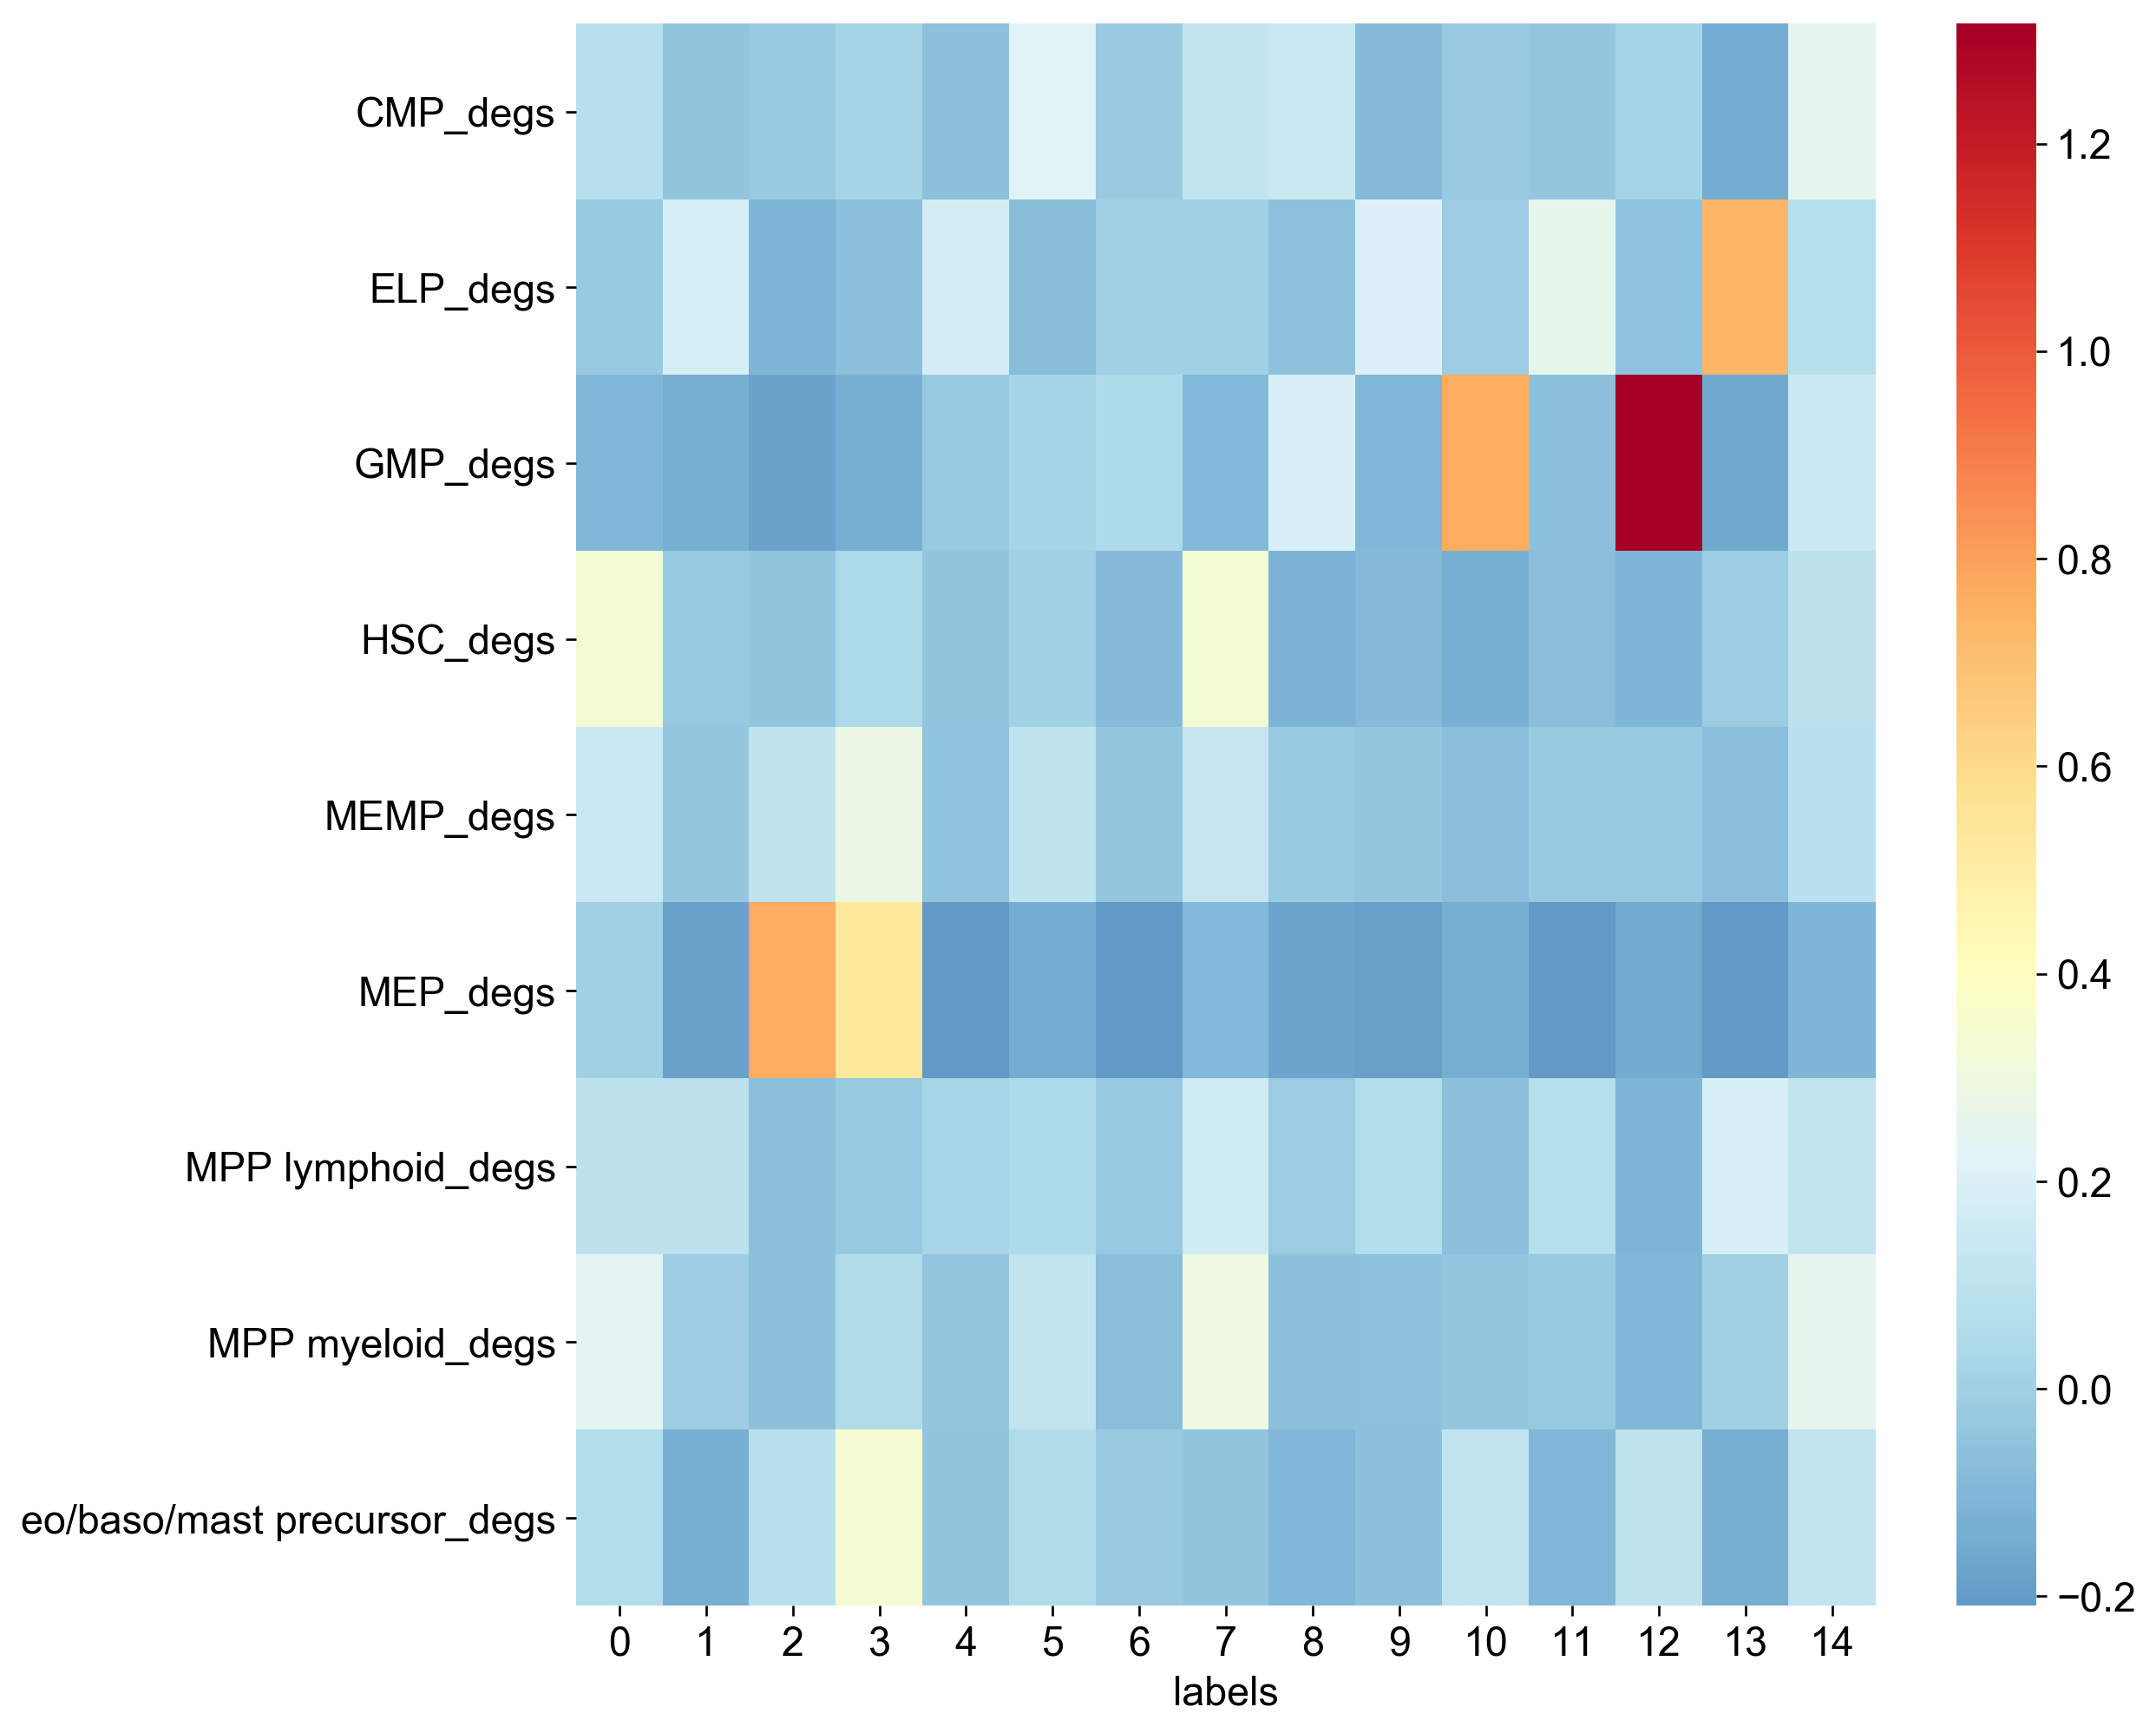

In [53]:
plt.figure(figsize=(10, 10))
fig = sns.heatmap(mean_enrichment_scores_df, annot=True, fmt=".2", center=0.4, annot_kws={"size": 5}, cmap="RdYlBu_r").get_figure()
fig.savefig("figures/figs5c_ys_fbm_progen_comparison_numbers_yes_20200514.pdf")
# plot gene scores as a heatmap. 
plt.figure(figsize=(10, 10))
fig = sns.heatmap(mean_enrichment_scores_df, cmap="RdYlBu_r", center=0.4).get_figure() 
fig.savefig("figures/figs5c_ys_fbm_progen_comparison_numbers_no_20200514.pdf")

In [54]:
adata

AnnData object with n_obs × n_vars = 571 × 32084 
    obs: 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'cell.labels', 'fetal.ids', 'sort.ids', 'tissue', 'lanes', 'stages', 'sample.type', 'gender', 'AnnatomicalPart', 'doublets', 'LouvainClustering', 'predicted.cell.labels', 'full.ids', 'batch', 'bh_pval', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'n_counts', 'louvain', 'is_doublet', 'is_doublet_poptrim', 'res.30', 'backlabeled_1', 'leiden', '__is_in_cluster__', 'CMP_degs', 'ELP_degs', 'GMP_degs', 'HSC_degs', 'MEMP_degs', 'MEP_degs', 'MPP lymphoid_degs', 'MPP myeloid_degs', 'eo/baso/mast precursor_degs', 'labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'cell.labels_colors', 'orig.ident_colors', 'leiden', 'leiden_colors', 'rank_genes_groups', 'rank_genes_groups_filtered'
    obsm: 'X_pca', 'X_umap', 'X_orig_pca'
    varm: 'PCs'

# Save data

In [55]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [56]:
adata.X

<571x32084 sparse matrix of type '<class 'numpy.float32'>'
	with 1434697 stored elements in Compressed Sparse Row format>

In [57]:
adata.raw.X

<571x32084 sparse matrix of type '<class 'numpy.float32'>'
	with 1994008 stored elements in Compressed Sparse Row format>

In [58]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/figs5c_ys_fbm_progen_enrichment_comparison_20200514.h5ad")

# Reload and annotate

# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.2 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load the YS progenitors

In [3]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/figs5c_ys_fbm_progen_enrichment_comparison_20200514.h5ad")

In [4]:
adata.shape

(571, 32084)

In [5]:
# read in annotation.csv which contains: 'Cluster' column for leiden clusters and 'Category' column for annotations
annotation = pd.read_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/resources_for_pipelines/ys_progen_annotation.csv", index_col=False)

In [6]:
# convert the clusters column to a string (so that it can be input into the replace function, which acts on strings)
annotation.Cluster = annotation.Cluster.apply(str)
# make a temp metadata column for new cell labels from the leiden clusters
adata.obs["old_cell.labels"] = adata.obs["cell.labels"]
adata.obs["cell.labels"] = adata.obs["leiden"]

In [7]:
# save the clusters/categories columns as named lists 
clusters = annotation["Cluster"].tolist()
categories = annotation["Category"].tolist()
# replace all values in new.cell.labels column matchin clusters values with categories values
adata.obs["cell.labels"] = adata.obs["cell.labels"].replace(clusters, categories)

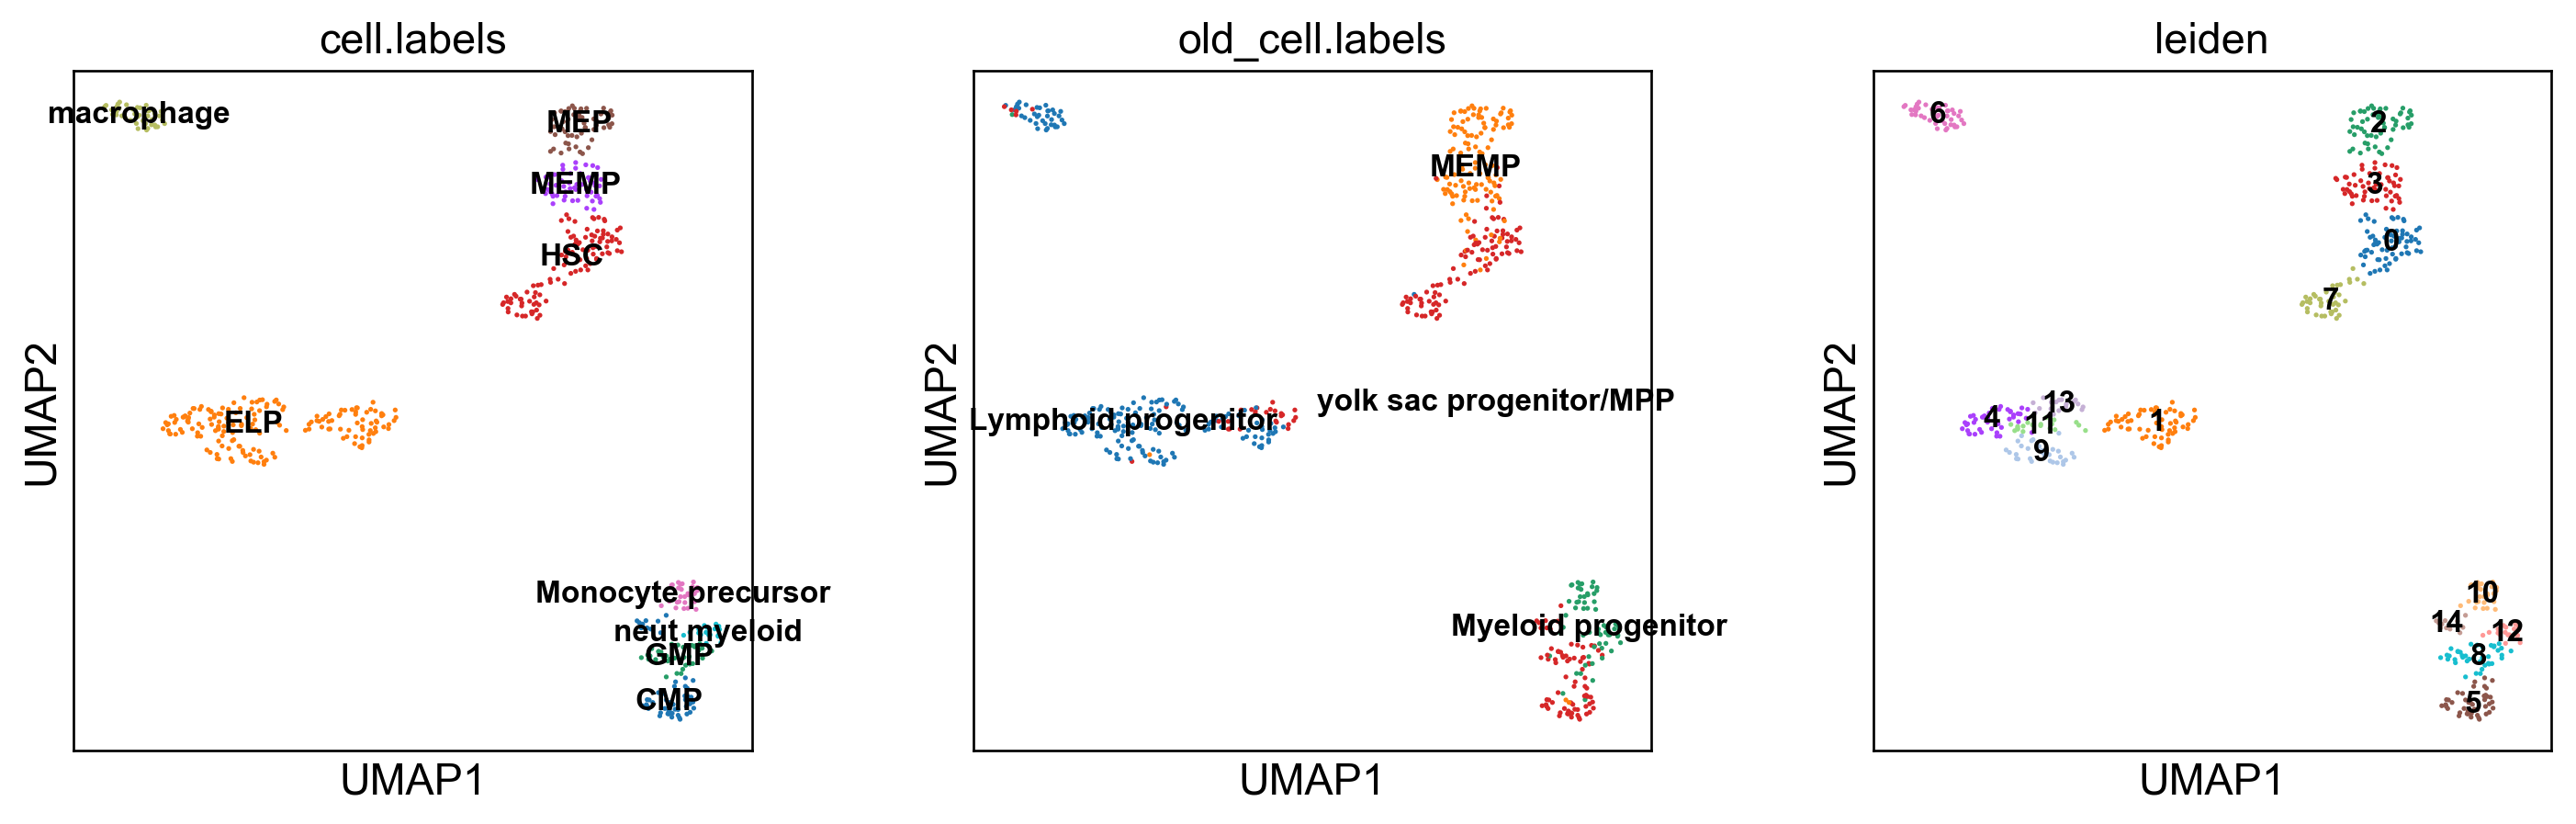

In [11]:
# lets look into proliferation..
sc.pl.umap(adata, color=["cell.labels", "old_cell.labels", "leiden"], legend_loc="on data", legend_fontsize=10, size=10)

In [12]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CMP                    55
ELP                   174
GMP                    40
HSC                   105
MEMP                   55
MEP                    56
Monocyte precursor     26
macrophage             42
neut myeloid           18
dtype: int64

In [13]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/figs5c_ys_fbm_progen_enrichment_comparison_20200514.h5ad")

# Load YS progenitors and save metadata

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/figs5c_ys_fbm_progen_enrichment_comparison_20200514.h5ad")

In [4]:
pd.DataFrame(adata.obs).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/resources_for_pipelines/ys_progen_annot_20200605.csv")

# Load YS progenitors and rename neut myeloid to MOP

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/figs5c_ys_fbm_progen_enrichment_comparison_20200514.h5ad")

In [4]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CMP                    55
ELP                   174
GMP                    40
HSC                   105
MEMP                   55
MEP                    56
MOP                    18
Monocyte precursor     26
macrophage             42
dtype: int64

In [5]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].replace(["neut myeloid", "Monocyte precursor"], ["MOP", "promonocyte"])

In [6]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CMP             55
ELP            174
GMP             40
HSC            105
MEMP            55
MEP             56
MOP             18
macrophage      42
promonocyte     26
dtype: int64

In [7]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/figs5c_ys_fbm_progen_enrichment_comparison_20200514.h5ad")

... storing 'cell.labels' as categorical
